# Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.metrics import silhouette_score, silhouette_samples

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

# Setup dataset parameters

In [2]:
#Set global variables
acores = 12
suffix = 'new'

#Set run parameters
run_genelists = True
plot_overlap_hist = True
plot_sep_hist = True
plot_overlap_matrix = True
make_peak_bed = True

#Specifies names
formatted_multicov = ''
unformatted_multicov = ''
standardized_multicov = ''
prox_peaks_file = ''

if 'distal' in suffix:
    formatted_multicov = 'OmniATAC_for_Mfuzz_distal.tsv'
    unformatted_multicov = formatted_multicov.split('.')[0] + '_unformatted.tsv'
    standardized_multicov = formatted_multicov.split('.')[0] + '_standardized.tsv'
    prox_peaks_file = "OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max.tsv"
elif 'new' in suffix:
    formatted_multicov = 'OmniATAC_for_Mfuzz_new.tsv'
    unformatted_multicov = formatted_multicov.split('.')[0] + '_unformatted.tsv'
    standardized_multicov = formatted_multicov.split('.')[0] + '_standardized.tsv'
    prox_peaks_file = "OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max.tsv"

#Makes directory
Mfuzz_folder = 'Mfuzz_' + str(acores) + 'acores_' + suffix
if not os.path.exists(Mfuzz_folder):
    os.makedirs(Mfuzz_folder)
Mfuzz_folder_loc = '/Users/dennis/Labwork/Bioinformatics/Omni-ATAC-Seq/OmniATAC_bothruns_peaks/' + Mfuzz_folder + '/'

# Load in dataset, generate cluster list files

In [3]:
#Takes the Mfuzz cmeans acores file and breaks 
lines = ''
    
with open('Mfuzz_cmeans_' + str(acores) + 'acores_' + suffix + '.txt') as v:
    lines = v.readlines()
    indices = [i for i, x in enumerate(lines) if x == "CLUSTER NUMBER\n"]
    pairs = [[indices[i], indices[i+1]] if i < len(indices) - 1 else [indices[i], -1] for i in np.arange(0, len(indices))]
    
    dictionary = {}
    for rnge in pairs:
        dictionary['_'.join(str(v) for v in rnge)] = lines[rnge[0]:rnge[1]]
    
    i = 1
    for item in dictionary:
        with open(Mfuzz_folder_loc + 'Mfuzz_' + str(acores) + 'acores_acore_' + str(i) + '_' + suffix + '.txt', 'w+') as outfile:
            for line in dictionary[item]:
                outfile.write(line)
        i = i + 1

# Convert cluster list files to gene name files

In [40]:
name_generator = [Mfuzz_folder_loc + 'Mfuzz_' + str(acores) + 'acores_acore_' + str(i) + '_' + suffix + '.txt' for i in np.arange(1, acores + 1)]
multicov = pd.DataFrame(pd.read_csv(unformatted_multicov, sep = '\t')).rename(columns = {'GENE.ID':'contig_start_end', 'GENE.NAME':'Nearby_Gene'})

prox_peaks = pd.DataFrame(pd.read_csv(prox_peaks_file, sep="\t")).drop_duplicates(subset='contig_start_end', keep='first')
prox_peaks = prox_peaks[prox_peaks['max_diff'] <= 4]
display(prox_peaks)
prox_peaks = prox_peaks.merge(multicov)

groups_dict = {}
genelist_dict = {}
hist_dict = {}
uniq_dict = {}
all_list = []

for file in name_generator:
    group_num = file.split('_')[-2].split('.')[0]
    groups_dict[file] = pd.read_csv(file, skiprows = 3, header = None, sep = ' ')
    groups_dict[file] = groups_dict[file].merge(prox_peaks, left_on = 0, right_on = 'contig_start_end')
    genelist_dict[file] = groups_dict[file]['Nearby_Gene'].unique()
    hist_dict[file] = list(groups_dict[file]['max_all'].values) + [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
    print(len(hist_dict[file]) - 15)
    uniq_dict[file] = len(groups_dict[file]['max_all'].unique())
    all_list = all_list + list(groups_dict[file]['Nearby_Gene'].unique())

if run_genelists:
    for lst in genelist_dict:
        group_num = lst.split('_')[-2].split('.')[0]
        filename = Mfuzz_folder_loc + '/Mfuzz_' + str(acores) + 'acores_acore_' + group_num + '_genelist_' + suffix + '.txt'
        with open(filename, 'w+') as outfile:
            for item in genelist_dict[lst]:
                if str(item) == 'nan':
                    continue
                else:
                    outfile.write(str(item) + '\n')
                
    all_set = set(all_list)
    with open(Mfuzz_folder_loc + 'Mfuzz_' + str(acores) + 'acores_acore_all_genelist_' + suffix + '.txt', 'w+') as outfile:
        for item in all_set:
            if str(item) == 'nan':
                continue
            else:
                outfile.write(str(item) + '\n')

    stable_peaks = pd.DataFrame(pd.read_csv(formatted_multicov, sep = '\t')).rename(columns = {'GENE.ID':'contig_start_end', 'GENE.NAME':'Nearby_Gene'})
    all_list_2 = list(stable_peaks['Nearby_Gene'].unique())
    with open(Mfuzz_folder_loc + 'Mfuzz_' + str(acores) + 'acores_acore_all_genelist2_' + suffix + '.txt', 'w+') as outfile:
        for item in all_list_2:
            if str(item) == 'nan':
                continue
            else:
                outfile.write(str(item) + '\n')

contig_start_end  max_all  max_S21S22  max_diff
0       phaw_50.001137b_10047943_10049274     24.0        23.0       1.0
1       phaw_50.282861e_14337153_14338358     21.0        21.0       0.0
2       phaw_50.283823c_56423509_56424634     27.0        27.0       0.0
3         phaw_50.283817d_2608098_2609434     27.0        27.0       0.0
4         phaw_50.282654b_8813983_8815092     21.0        21.0       0.0
...                                   ...      ...         ...       ...
159322             phaw_50.110945_193_446     19.0        19.0       0.0
159323    phaw_50.283743b_2685218_2685495     16.0        16.0       0.0
159324  phaw_50.000135c_16666556_16667003     27.0        27.0       0.0
159325  phaw_50.283869c_22485630_22486651     25.0        25.0       0.0
159326    phaw_50.283355a_5169527_5169940     16.0        13.0       3.0

[145078 rows x 4 columns]

23923
13489
8723
7118
9687
22862
6378
10859
6519
11476
7908
8656


# Plot overlapping histogram of bins

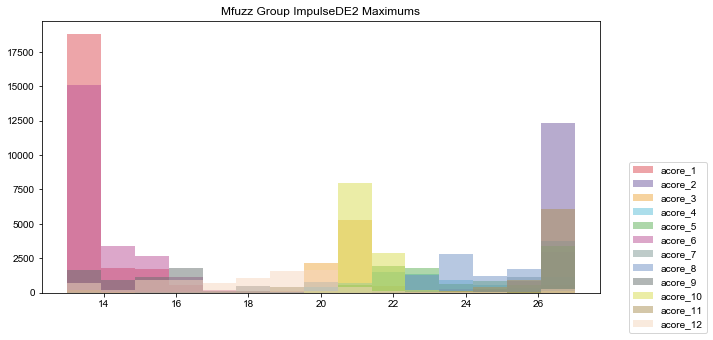

In [42]:
if plot_overlap_hist:

    hists = plt.figure(figsize=(10,5))
    colors_dict = {
        5: ['#fccd35', '#6d6fb4', '#789a97', '#ef3d4f', '#75c043'],
        6: ['#fccd35', '#6d6fb4', '#789a97', '#ef3d4f', '#75c043', '#ca4699'],
        7: ['#6d6fb4', '#789a97', '#b1914c', '#ef3d4f', '#75c043', '#ca4699', '#fccd35'],
        8: ['#789a97', '#b1914c', '#6d6fb4', '#ef3d4f', '#fccd35', '#75c043', '#ca4699', '#5dcae8'],
        9: ['#789a97', '#b1914c', '#6d6fb4', '#ef3d4f', '#fccd35', '#75c043', '#ca4699', '#5dcae8', '#ecb18e'],
        10: ['#789a97', '#b1914c', '#6d6fb4', '#ef3d4f', '#fccd35', '#75c043', '#ca4699', '#5dcae8', '#ecb18e', '#000000'],
        12: ['#dd4d54', '#70599f', '#efa941', '#5cbfd8', '#5fb157', '#bb5196', '#7f9996', '#7193c5', '#66706e', '#d9dd50', '#ac9156', '#f6d6be']}

    colors = colors_dict[acores]
    for lst in hist_dict:
        group_num = lst.split('_')[-2].split('.')[0]
        plt.hist(hist_dict[lst], bins=15, alpha=0.5, label='acore_' + str(group_num), color = colors[int(group_num)-1])
        plt.legend(loc = 'upper right', bbox_to_anchor=(1.2, .5, 0, 0))
        plt.title('Mfuzz Group ImpulseDE2 Maximums')
    #plt.savefig(Mfuzz_folder_loc + "Mfuzz_" + str(acores) + "_group_hist_" + suffix + ".svg", bbox = 'tight')

# Plot separated histograms of bins

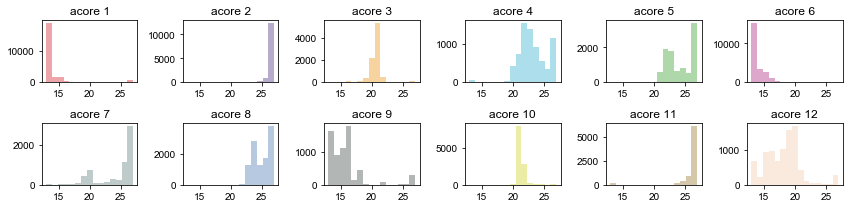

In [263]:
if plot_sep_hist:
    hists = plt.figure(figsize=(12,2))
    colors = colors_dict[acores]

    for lst in hist_dict:
        group_num = lst.split('_')[-2].split('.')[0]
        plt.subplot(2, 6, int(group_num))
        plt.tight_layout()
        plt.hist(hist_dict[lst], bins=15, alpha=0.5, label='acore_' + str(group_num), color = colors[int(group_num)-1])
        plt.title('acore ' + str(group_num))
    plt.savefig(Mfuzz_folder_loc + "Mfuzz_" + str(acores) + "acores_group_hist_separated_" + suffix + ".svg", bbox = 'tight')

# Plot overlap matrix

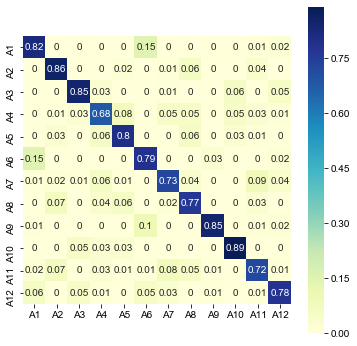

In [245]:
if plot_overlap_matrix:

    mfuzz_cmeans_overlap = pd.DataFrame(pd.read_csv('Mfuzz_cmeans_' + str(acores) + 'acores_overlap_' + suffix + '.txt', sep = ' '))
    mfuzz_cmeans_overlap = mfuzz_cmeans_overlap.transpose().round(2)
    mfuzz_cmeans_overlap.columns = ['A' + str(i) for i in np.arange(1, acores + 1)]
    mfuzz_cmeans_overlap.index = ['A' + str(i) for i in np.arange(1, acores + 1)]

    plt.figure(figsize=(6,6))
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    sns.heatmap(mfuzz_cmeans_overlap, square = True, annot = True, cmap='YlGnBu')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.savefig(Mfuzz_folder_loc + "Mfuzz_" + str(acores) + "acores_overlap_" + suffix + ".svg", bbox='tight')
    plt.show()

# Calculate best cluster per peak

In [5]:
mfuzz_cmeans = pd.DataFrame(pd.read_csv('Mfuzz_cmeans_' + str(acores) + 'acores_' + suffix + '.csv'))
mfuzz_cmeans_val = mfuzz_cmeans.filter(regex=("cluster.*"))
mfuzz_cmeans['best_cluster'] = mfuzz_cmeans_val.idxmax(axis = 1).str.split('.', expand = True)[1].astype(int)
mfuzz_cmeans['topval'] = mfuzz_cmeans_val.max(axis = 1)

multicov = pd.DataFrame(pd.read_csv(standardized_multicov, sep = '\t'))
multicov['Gene.Name'] = multicov.index
multicov.index = mfuzz_cmeans['gene.id']
multicov['best_cluster'] = mfuzz_cmeans['best_cluster'].values
multicov['topval'] = mfuzz_cmeans['topval'].values

display(mfuzz_cmeans)
display(multicov)

Unnamed: 0                          gene.id  \
0              phaw_50.000003_4302_5642         phaw_50.000003_4302_5642   
1          phaw_50.000014_206406_207519     phaw_50.000014_206406_207519   
2          phaw_50.000014_238984_239410     phaw_50.000014_238984_239410   
3          phaw_50.000014_239711_240244     phaw_50.000014_239711_240244   
4            phaw_50.000019_87818_88035       phaw_50.000019_87818_88035   
...                                 ...                              ...   
145066  phaw_50.283875b_1496273_1496592  phaw_50.283875b_1496273_1496592   
145067  phaw_50.283875b_1535466_1535680  phaw_50.283875b_1535466_1535680   
145068  phaw_50.283875b_1546841_1547714  phaw_50.283875b_1546841_1547714   
145069         phaw_50.283876_1905_3313         phaw_50.283876_1905_3313   
145070       phaw_50.283876_24624_25204       phaw_50.283876_24624_25204   

       gene.names     cluster.1     cluster.2     cluster.3     cluster.4  \
0               .  9.994010e-01  5.790747e-13  1.883148e-11  6.694112e-11   
1               .  9.828529e-01  2.017716e-17  1.143225e-14  1.578553e-15   
2               .  1.365975e-01  1.657034e-04  1.372993e-01  4.200990e-03   
3               .  2.352251e-01  3.158311e-04  4.446058e-03  2.902383e-02   
4          GXYLT1  6.470466e-01  6.232971e-10  4.329016e-05  2.896085e-07   
...           ...           ...           ...           ...           ...   
145066        NaN  2.598399e-07  9.786156e-01  1.151727e-08  3.262950e-06   
145067        NaN  2.128232e-10  9.984273e-01  1.464373e-10  2.302658e-07   
145068        NaN  3.550204e-11  4.687916e-08  1.915988e-06  2.112295e-03   
145069          .  9.851879e-01  9.503038e-18  1.183082e-15  3.866777e-16   
145070          .  7.389455e-01  5.008702e-17  1.228930e-14  3.429092e-15   

           cluster.5     cluster.6     cluster.7     cluster.8     cluster.9  \
0       2.005807e-13  5.972740e-04  2.503288e-09  4.488971e-12  8.749923e-09   
1       1.163605e-17  1.714713e-02  1.142276e-14  6.012047e-17  4.049210e-11   
2       1.931423e-04  2.036416e-01  4.328066e-03  1.003766e-04  7.819395e-02   
3       4.280388e-04  5.775303e-02  1.270159e-01  7.009890e-03  5.200928e-03   
4       1.384148e-09  1.533563e-01  5.736842e-07  2.184389e-09  3.317029e-05   
...              ...           ...           ...           ...           ...   
145066  1.655319e-05  1.033368e-07  3.477355e-05  2.067094e-03  1.881097e-07   
145067  2.418778e-06  5.623630e-11  7.385487e-06  1.476910e-03  6.936120e-11   
145068  1.449978e-01  2.448838e-11  2.620670e-08  2.339193e-06  6.932836e-11   
145069  3.220742e-18  1.481212e-02  5.964936e-15  2.781011e-17  3.826566e-11   
145070  2.842864e-17  2.610545e-01  2.188942e-14  1.897627e-16  5.109555e-10   

          cluster.10    cluster.11    cluster.12  best_cluster    topval  
0       1.608941e-13  2.372503e-08  1.711270e-06             1  0.999401  
1       4.542661e-17  1.580298e-13  1.343111e-09             1  0.982853  
2       3.070921e-03  1.943749e-02  4.127710e-01            12  0.412771  
3       2.289371e-04  7.758979e-02  4.557627e-01            12  0.455763  
4       3.037017e-08  1.186203e-06  1.995186e-01             1  0.647047  
...              ...           ...           ...           ...       ...  
145066  3.988941e-08  1.926202e-02  5.889715e-08             2  0.978616  
145067  8.140470e-10  8.576438e-05  2.911083e-10             2  0.998427  
145068  8.528856e-01  1.680410e-08  7.388877e-10            10  0.852886  
145069  7.036595e-18  9.184764e-14  1.743660e-10             1  0.985188  
145070  7.987274e-17  3.363832e-13  5.858971e-10             1  0.738945  

[145071 rows x 17 columns]

S13A      S13B      S14A      S14B  \
gene.id                                                                   
phaw_50.000003_4302_5642         1.280766  3.321805  0.276840  1.148015   
phaw_50.000014_206406_207519     2.033280  3.462084  0.337477  0.972501   
phaw_50.000014_238984_239410     1.426282  1.793443  0.578986  1.369795   
phaw_50.000014_239711_240244     0.936963  1.176528 -0.979552 -0.300786   
phaw_50.000019_87818_88035       1.062525  3.488467  0.216266  0.752230   
...                                   ...       ...       ...       ...   
phaw_50.283875b_1496273_1496592  1.733407 -0.311124 -0.266678 -0.133339   
phaw_50.283875b_1535466_1535680 -0.537560  0.172177 -1.050148 -1.010718   
phaw_50.283875b_1546841_1547714 -1.056819 -0.166099 -1.409745 -0.283742   
phaw_50.283876_1905_3313         1.809053  3.320787  0.932177  0.862027   
phaw_50.283876_24624_25204       1.889539  3.295876  1.101373  1.109100   

                                     S15A      S15B      S17A      S17B  \
gene.id                                                                   
phaw_50.000003_4302_5642         1.264172  0.011339  0.202168  0.426184   
phaw_50.000014_206406_207519     0.878691  0.149856  0.582827  0.828177   
phaw_50.000014_238984_239410    -0.353040 -0.720202 -0.127094 -0.240067   
phaw_50.000014_239711_240244     0.996854 -0.001331  0.278161  0.397943   
phaw_50.000019_87818_88035       0.216266 -0.263281  1.654906  0.977899   
...                                   ...       ...       ...       ...   
phaw_50.283875b_1496273_1496592  0.355571 -0.444463  0.222232 -1.155605   
phaw_50.283875b_1535466_1535680 -0.576990 -0.419271 -0.419271 -1.129008   
phaw_50.283875b_1546841_1547714 -0.829937 -1.073625 -0.603056 -0.603056   
phaw_50.283876_1905_3313         0.984790  0.472695  0.721727  1.061955   
phaw_50.283876_24624_25204       0.954557  0.660927  0.568201  0.861832   

                                     S18A      S18B  ...      S24B      S25A  \
gene.id                                              ...                       
phaw_50.000003_4302_5642         0.011339  1.181203  ...  0.152387 -0.046739   
phaw_50.000014_206406_207519     0.395206  0.907555  ... -0.636708 -0.600627   
phaw_50.000014_238984_239410     0.466013  0.776688  ... -1.059120 -0.833174   
phaw_50.000014_239711_240244    -0.240895  0.158379  ...  1.076709  0.437871   
phaw_50.000019_87818_88035      -0.263281 -0.263281  ... -0.799245 -0.940288   
...                                   ...       ...  ...       ...       ...   
phaw_50.283875b_1496273_1496592 -0.711141 -0.177785  ...  1.155605  1.066712   
phaw_50.283875b_1535466_1535680 -0.182692 -0.143262  ...  1.591651  0.527046   
phaw_50.283875b_1546841_1547714 -0.989594 -0.124084  ...  2.052295 -0.115681   
phaw_50.283876_1905_3313         0.079854  0.862027  ... -0.646199 -0.372614   
phaw_50.283876_24624_25204      -0.119513  0.599110  ... -0.606322 -0.420871   

                                     S25B      S26A      S26B      S27A  \
gene.id                                                                   
phaw_50.000003_4302_5642        -0.801758  0.069417 -0.610929 -1.365947   
phaw_50.000014_206406_207519    -0.506817 -0.521249 -0.788248 -1.091327   
phaw_50.000014_238984_239410    -1.087363 -1.030877 -1.059120  0.889661   
phaw_50.000014_239711_240244     1.276346 -1.558500 -1.298972 -1.398790   
phaw_50.000019_87818_88035      -0.771036 -0.968496 -0.968496 -0.996705   
...                                   ...       ...       ...       ...   
phaw_50.283875b_1496273_1496592  1.244497  1.644514  1.422283  0.488910   
phaw_50.283875b_1535466_1535680  1.867660  2.104239  1.355072  0.132747   
phaw_50.283875b_1546841_1547714  0.060782  0.144812 -0.040054 -0.678683   
phaw_50.283876_1905_3313        -0.663737 -0.523436 -0.618139 -1.221430   
phaw_50.283876_24624_25204      -0.884498 -0.374508 -0.814954 -1.340398   

                                     S27B  Gene.Name  best_cluster  

# Convert clusters to peak and mRNA bed files

In [247]:
mfuzz_cmeans_export = mfuzz_cmeans
mfuzz_cmeans_export['contig'] = 'phaw_' + mfuzz_cmeans['gene.id'].str.split('_', expand = True)[1]
mfuzz_cmeans_export['start'] =  mfuzz_cmeans['gene.id'].str.split('_', expand = True)[2]
mfuzz_cmeans_export['end'] = mfuzz_cmeans['gene.id'].str.split('_', expand = True)[3]
mfuzz_cmeans_export['orientation'] = '+'
mfuzz_cmeans_export['score'] = '.'
mfuzz_cmeans_export = mfuzz_cmeans_export[['contig', 'start', 'end', 'gene.id', 'score', 'orientation', 'best_cluster']]
display(mfuzz_cmeans_export)

mRNAs = 'phaw_5.0.eggnog.resorted.mRNA.bed'
total = 0

if make_peak_bed:
    
    for i in np.arange(1, acores + 1):
        acore_prefix = 'Mfuzz_' + str(acores) + 'acores_acore' + str(i)
        acore_bed_name = Mfuzz_folder_loc + acore_prefix + '_peaks_' + suffix + '.bed'
        acore_bed_out = Mfuzz_folder_loc + acore_prefix + '_closest_mRNA_' + suffix + '.tsv'
        acore_df = mfuzz_cmeans_export[mfuzz_cmeans_export['best_cluster'] == i].drop(columns = 'best_cluster')
        lines = len(acore_df)
        acore_df.to_csv(acore_bed_name, sep = '\t', header = False, index = False)
        !bedtools closest -a $acore_bed_name -b $mRNAs -t all > $acore_bed_out
        temp_df = pd.read_csv(acore_bed_out, sep = '\t', header = None)
        temp_df = temp_df[temp_df[7] != -1]
        newbed = acore_bed_out.replace('.tsv', '.bed')
        newbed_df = temp_df[[6, 7, 8, 9, 10, 11]].drop_duplicates()
        newbed_df.to_csv(newbed, sep = '\t', header = False, index = False)
        total = total + lines
        print(total)

contig    start      end                          gene.id  \
0        phaw_50.000003     4302     5642         phaw_50.000003_4302_5642   
1        phaw_50.000014   206406   207519     phaw_50.000014_206406_207519   
2        phaw_50.000014   238984   239410     phaw_50.000014_238984_239410   
3        phaw_50.000014   239711   240244     phaw_50.000014_239711_240244   
4        phaw_50.000019    87818    88035       phaw_50.000019_87818_88035   
...                 ...      ...      ...                              ...   
145066  phaw_50.283875b  1496273  1496592  phaw_50.283875b_1496273_1496592   
145067  phaw_50.283875b  1535466  1535680  phaw_50.283875b_1535466_1535680   
145068  phaw_50.283875b  1546841  1547714  phaw_50.283875b_1546841_1547714   
145069   phaw_50.283876     1905     3313         phaw_50.283876_1905_3313   
145070   phaw_50.283876    24624    25204       phaw_50.283876_24624_25204   

       score orientation  best_cluster  
0          .           +             1  
1          .           +             1  
2          .           +            12  
3          .           +            12  
4          .           +             1  
...      ...         ...           ...  
145066     .           +             2  
145067     .           +             2  
145068     .           +            10  
145069     .           +             1  
145070     .           +             1  

[145071 rows x 7 columns]

24492
38472
47535
55684
65983
89370
96542
108226
115022
126767
135628
145071


# Setup table for t-SNE

In [6]:
multicov['contig_start_end'] = multicov.index.values
prox_peaks = pd.DataFrame(pd.read_csv(prox_peaks_file, sep="\t")).drop_duplicates(subset='contig_start_end', keep='first')
prox_peaks = prox_peaks[prox_peaks['max_diff'] <= 4]
display(prox_peaks)
ImpulseDE2_sorted = prox_peaks.merge(multicov)

conditions = [
    (ImpulseDE2_sorted['max_all'] <= 15),
    (ImpulseDE2_sorted['max_all'] >= 16) & (ImpulseDE2_sorted['max_all'] <= 18),
    (ImpulseDE2_sorted['max_all'] >= 19) & (ImpulseDE2_sorted['max_all'] <= 21),
    (ImpulseDE2_sorted['max_all'] >= 22) & (ImpulseDE2_sorted['max_all'] <= 24),
    (ImpulseDE2_sorted['max_all'] >= 25)
    ]

# create a list of the values we want to assign for each condition
values = ['quint1', 'quint2', 'quint3', 'quint4', 'quint5']

ImpulseDE2_sorted['quint'] = np.select(conditions, values)

display(ImpulseDE2_sorted)

acore_palette = {
    6:'#bb5196',
    1:'#dd4d54',
    12:'#f6d6be',
    3:'#efa941',
    10:'#d9dd50',
    5:'#5fb157',
    4:'#5cbfd8',
    8:'#7193c5',
    2:'#70599f',
    11:'#ac9156',
    7:'#7f9996',
    9:'#66706e'
}

    
quint_palette = {'quint1':'#da3832', 'quint2':'#d9dd50', 'quint3':'#53a9dc', 'quint4':'#922d61', 'quint5':'#bd9b72'}

stage_palette = {
    13 : '#e79ec0',
    14 : '#af3034',
    15 : '#e26e47',
    16 : '#ea973e',
    17 : '#f8cd47',
    18 : '#a3c754',
    19 : '#529650',
    20 : '#429798',
    21 : '#3f6695',
    22 : '#c49dc3',
    23 : '#603c90',
    24 : '#ccca73',
    25 : '#92683c',
    26 : '#999847',
    27 : '#603635'
}

stages = ['S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB', 'S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']

contig_start_end  max_all  max_S21S22  max_diff
0       phaw_50.001137b_10047943_10049274     24.0        23.0       1.0
1       phaw_50.282861e_14337153_14338358     21.0        21.0       0.0
2       phaw_50.283823c_56423509_56424634     27.0        27.0       0.0
3         phaw_50.283817d_2608098_2609434     27.0        27.0       0.0
4         phaw_50.282654b_8813983_8815092     21.0        21.0       0.0
...                                   ...      ...         ...       ...
159322             phaw_50.110945_193_446     19.0        19.0       0.0
159323    phaw_50.283743b_2685218_2685495     16.0        16.0       0.0
159324  phaw_50.000135c_16666556_16667003     27.0        27.0       0.0
159325  phaw_50.283869c_22485630_22486651     25.0        25.0       0.0
159326    phaw_50.283355a_5169527_5169940     16.0        13.0       3.0

[145078 rows x 4 columns]

contig_start_end  max_all  max_S21S22  max_diff  \
0       phaw_50.001137b_10047943_10049274     24.0        23.0       1.0   
1       phaw_50.282861e_14337153_14338358     21.0        21.0       0.0   
2       phaw_50.283823c_56423509_56424634     27.0        27.0       0.0   
3         phaw_50.283817d_2608098_2609434     27.0        27.0       0.0   
4         phaw_50.282654b_8813983_8815092     21.0        21.0       0.0   
...                                   ...      ...         ...       ...   
145066             phaw_50.110945_193_446     19.0        19.0       0.0   
145067    phaw_50.283743b_2685218_2685495     16.0        16.0       0.0   
145068  phaw_50.000135c_16666556_16667003     27.0        27.0       0.0   
145069  phaw_50.283869c_22485630_22486651     25.0        25.0       0.0   
145070    phaw_50.283355a_5169527_5169940     16.0        13.0       3.0   

            S13A      S13B      S14A      S14B      S15A      S15B  ...  \
0      -0.809683 -0.698583 -0.919100 -0.845033 -0.907316 -0.988116  ...   
1      -0.642264 -0.444750 -0.721457 -0.538849 -0.613383 -0.666488  ...   
2      -0.776727 -0.746339 -0.778753 -0.780779 -0.825349 -0.880048  ...   
3      -0.796797 -0.637369 -0.879978 -0.814127 -0.900773 -0.911170  ...   
4      -0.267693 -0.098295 -0.498386 -0.137301 -0.382483 -0.563025  ...   
...          ...       ...       ...       ...       ...       ...  ...   
145066  0.248908  1.344104 -0.398253 -0.248908  0.099563 -0.298690  ...   
145067  0.569577  1.581858  0.326629  1.581858  0.529086 -0.199757  ...   
145068 -0.736377  1.868987 -0.139315 -0.193593 -1.224883 -0.790656  ...   
145069  1.176917  2.856368 -0.385362  0.200493  0.525968 -0.671780  ...   
145070  1.853670  3.554758  0.430942  0.925804 -0.187635  0.245369  ...   

            S25A      S25B      S26A      S26B      S27A      S27B  Gene.Name  \
0       1.314683  1.031883  1.080700  0.533616 -0.230617  0.313100  polybromo   
1      -0.437296 -0.402824 -0.476427 -0.537917 -0.677668 -0.579842        NaN   
2       1.153949  0.991877  1.950124  1.206622  1.046576  2.124351        NaN   
3       0.863342  0.714310  1.982809  1.632759  1.532249  2.346722        NaN   
4      -0.729080 -0.745796 -0.799291 -0.832724 -0.926339 -0.902935      shakB   
...          ...       ...       ...       ...       ...       ...        ...   
145066 -0.846287 -0.348471 -0.099563 -0.746724 -1.443667 -0.945851          .   
145067 -1.414495 -1.293021 -0.280739 -0.766634 -1.293021 -0.847617        NaN   
145068  0.023521  0.783418 -0.519264 -0.682099 -0.247871  1.217646        NaN   
145069  1.424278  0.278607 -0.528571 -0.880084 -1.036312 -1.179521        NaN   
145070 -0.435066 -0.527853  0.090725 -0.125777 -0.929928 -0.713426         sm   

        best_cluster    topval   quint  
0                  5  0.843439  quint4  
1                 10  1.000000  quint3  
2                  2  0.999996  quint5  
3                  2  0.999998  quint5  
4                 10  0.941678  quint3  
...              ...       ...     ...  
145066            12  0.984151  quint3  
145067            12  0.961038  quint2  
145068            11  0.470948  quint5  
145069             1  0.626245  quint5  
145070             1  0.652473  quint2  

[145071 rows x 38 columns]

# Run t-SNE on top_n clusters

In [276]:
top_n = 25000
perplexity = 100

multicov_top_n = ImpulseDE2_sorted.head(top_n).loc[:, stages].values

tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
tsne_results = tsne.fit_transform(multicov_top_n)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.062s...
[t-SNE] Computed neighbors for 25000 samples in 27.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


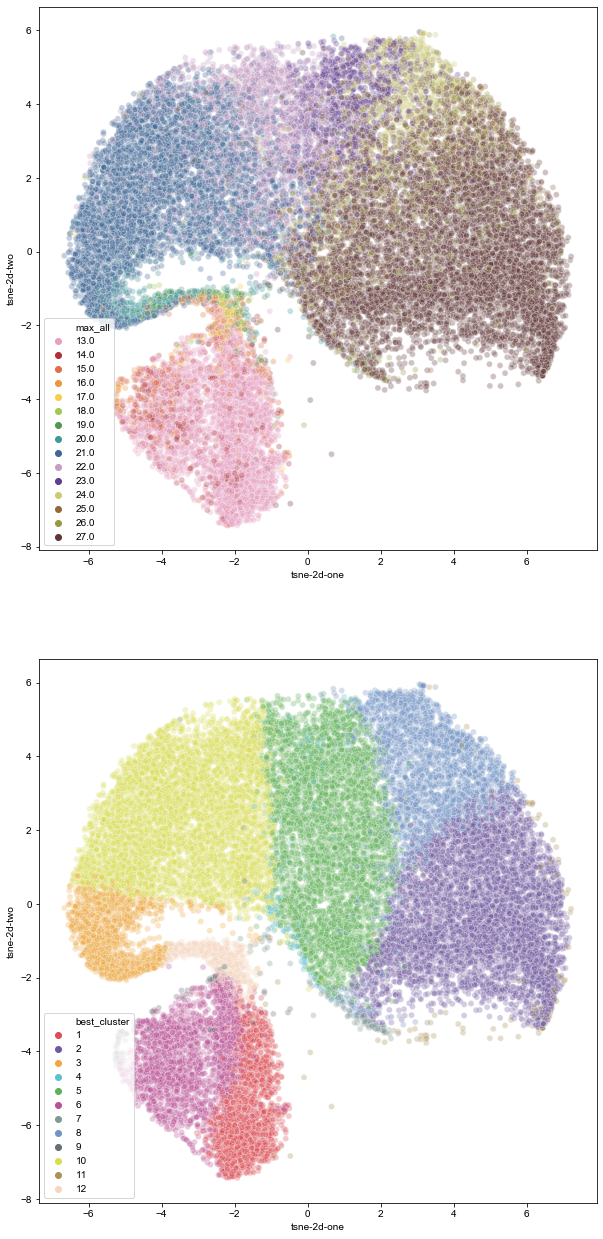

In [278]:
ImpulseDE2_sorted_top_n = ImpulseDE2_sorted.head(top_n)
ImpulseDE2_sorted_top_n['tsne-2d-one'] = tsne_results[:,0]
ImpulseDE2_sorted_top_n['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(10,22))
plt.subplot(2, 1, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="max_all",
    palette=stage_palette,
    data=ImpulseDE2_sorted_top_n,
    alpha=0.3
)
plt.subplot(2, 1, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="best_cluster",
    palette=acore_palette,
    data=ImpulseDE2_sorted_top_n,
    legend = 'full',
    alpha=0.3
)
plt.savefig(Mfuzz_folder_loc + 'ImpulseDE2_Mfuzz_top' + str(top_n) + '_p' + str(perplexity) + '_c' + str(acores) + '_tsne_multiplot_' + suffix + '.pdf')

# Plot representation of peaks in top_n t-SNE

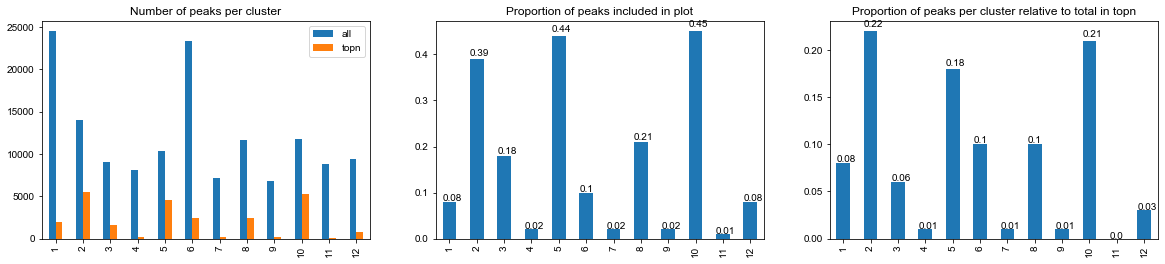

In [279]:
multicov_acores_hist = list(ImpulseDE2_sorted['best_cluster'])
multicov_value_counts = ImpulseDE2_sorted['best_cluster'].value_counts()

multicov_top_n_acores_hist = list(ImpulseDE2_sorted.head(top_n)['best_cluster'])
multicov_top_n_value_counts = ImpulseDE2_sorted.head(top_n)['best_cluster'].value_counts()

fig = plt.figure(figsize=(20, 4))

ax1 = fig.add_subplot(131)
ax1.set_title('Number of peaks per cluster')
multicov_barh = pd.DataFrame({'all': multicov_value_counts, 'topn': multicov_top_n_value_counts})
multicov_barh.plot.bar(ax = ax1)

ax2 = fig.add_subplot(132)
ax2.set_title('Proportion of peaks included in plot')
multicov_proportion_barh = multicov_barh.apply(lambda x: round(x['topn'] / x['all'], 2), axis = 1)
multicov_proportion_barh.plot.bar(ax = ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.02))
    
ax3 = fig.add_subplot(133)
ax3.set_title('Proportion of peaks per cluster relative to total in topn')
multicov_proportion_barh = multicov_barh.apply(lambda x: round(x['topn'] / sum(multicov_barh['topn']), 2), axis = 1)
multicov_proportion_barh.plot.bar(ax = ax3)
for p in ax3.patches:
    ax3.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.02))

fig.savefig(Mfuzz_folder_loc + 'ImpulseDE2_Mfuzz_top' + str(top_n) + '_p' + str(perplexity) + '_c' + str(acores) + '_tsne_representation_hists_' + suffix + '.pdf')

# Run t-SNE on a random sample of rand_n peaks

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.027s...
[t-SNE] Computed neighbors for 25000 samples in 44.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

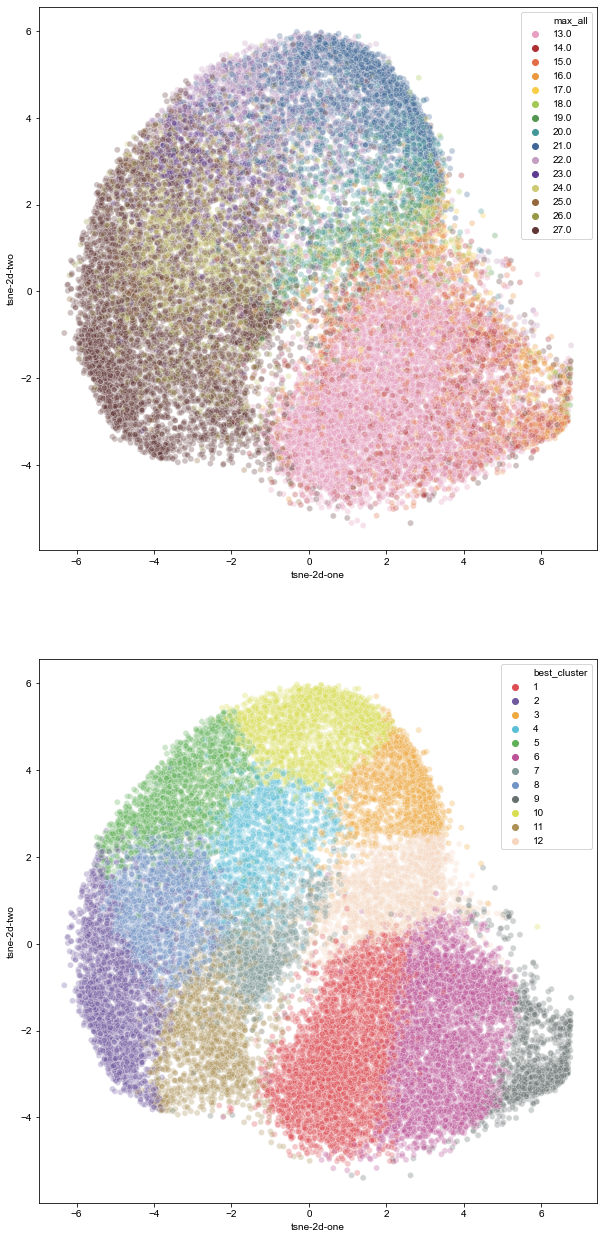

In [280]:
rand_n = 25000
perplexity = 100

multicov_rand_n = ImpulseDE2_sorted.sample(rand_n, axis = 'rows', random_state = 83193)
multicov_rand_n_matrix = multicov_rand_n.loc[:, stages].values

tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
tsne_results = tsne.fit_transform(multicov_rand_n_matrix)

multicov_rand_n['tsne-2d-one'] = tsne_results[:,0]
multicov_rand_n['tsne-2d-two'] = tsne_results[:,1]

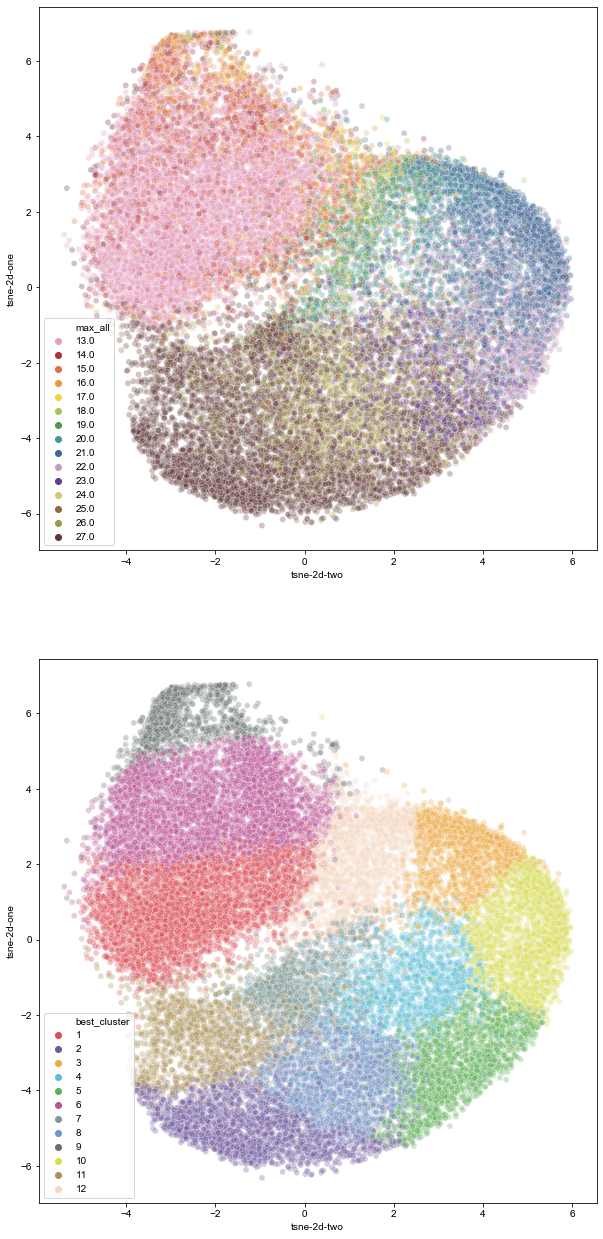

In [282]:
plt.figure(figsize=(10,22))
plt.subplot(2, 1, 1)
sns.scatterplot(
    x="tsne-2d-two", y="tsne-2d-one",
    hue="max_all",
    palette=stage_palette,
    data=multicov_rand_n,
    alpha=0.3
)
plt.subplot(2, 1, 2)
sns.scatterplot(
    x="tsne-2d-two", y="tsne-2d-one",
    hue="best_cluster",
    palette=acore_palette,
    data=multicov_rand_n,
    legend = 'full',
    alpha=0.3
)
plt.savefig(Mfuzz_folder_loc + 'ImpulseDE2_Mfuzz_rand' + str(rand_n) + '_p' + str(perplexity) + '_c' + str(acores) + '_tsne_multiplot_' + suffix + '.pdf')

# Plot representation of peaks in rand_n t-SNE

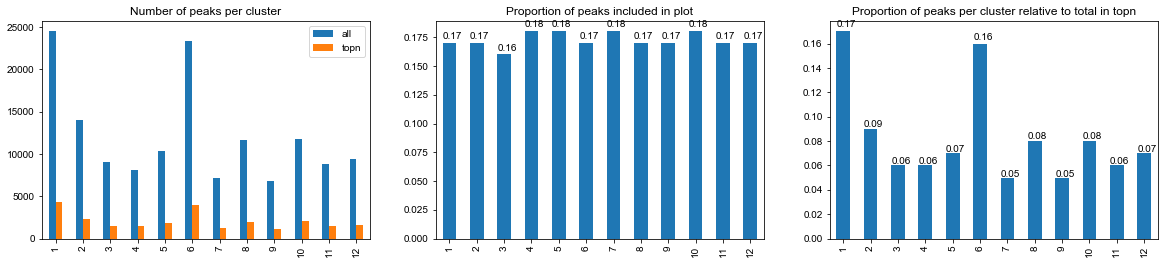

In [281]:
multicov_acores_hist = list(ImpulseDE2_sorted['best_cluster'])
multicov_value_counts = ImpulseDE2_sorted['best_cluster'].value_counts()

multicov_rand_n_acores_hist = list(multicov_rand_n['best_cluster'])
multicov_rand_n_value_counts = multicov_rand_n['best_cluster'].value_counts()

fig = plt.figure(figsize=(20, 4))

ax1 = fig.add_subplot(131)
ax1.set_title('Number of peaks per cluster')
multicov_barh = pd.DataFrame({'all': multicov_value_counts, 'topn': multicov_rand_n_value_counts})
multicov_barh.plot.bar(ax = ax1)

ax2 = fig.add_subplot(132)
ax2.set_title('Proportion of peaks included in plot')
multicov_proportion_barh = multicov_barh.apply(lambda x: round(x['topn'] / x['all'], 2), axis = 1)
multicov_proportion_barh.plot.bar(ax = ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.02))
    
ax3 = fig.add_subplot(133)
ax3.set_title('Proportion of peaks per cluster relative to total in topn')
multicov_proportion_barh = multicov_barh.apply(lambda x: round(x['topn'] / sum(multicov_barh['topn']), 2), axis = 1)
multicov_proportion_barh.plot.bar(ax = ax3)
for p in ax3.patches:
    ax3.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.02))

fig.savefig(Mfuzz_folder_loc + 'ImpulseDE2_Mfuzz_rand' + str(rand_n) + '_p' + str(perplexity) + '_c' + str(acores) + '_tsne_representation_hists_' + suffix + '.pdf')

# Silhouette Score

In [8]:
mfuzz_cmeans_dist = mfuzz_cmeans[[col for col in mfuzz_cmeans if col.startswith('cluster.')]]
mfuzz_cmeans_label = mfuzz_cmeans['best_cluster']
display(mfuzz_cmeans_dist)
display(mfuzz_cmeans_label)

shscore = silhouette_score(mfuzz_cmeans_dist, mfuzz_cmeans_label, sample_size = 1000)

cluster.1     cluster.2     cluster.3     cluster.4     cluster.5  \
0       9.994010e-01  5.790747e-13  1.883148e-11  6.694112e-11  2.005807e-13   
1       9.828529e-01  2.017716e-17  1.143225e-14  1.578553e-15  1.163605e-17   
2       1.365975e-01  1.657034e-04  1.372993e-01  4.200990e-03  1.931423e-04   
3       2.352251e-01  3.158311e-04  4.446058e-03  2.902383e-02  4.280388e-04   
4       6.470466e-01  6.232971e-10  4.329016e-05  2.896085e-07  1.384148e-09   
...              ...           ...           ...           ...           ...   
145066  2.598399e-07  9.786156e-01  1.151727e-08  3.262950e-06  1.655319e-05   
145067  2.128232e-10  9.984273e-01  1.464373e-10  2.302658e-07  2.418778e-06   
145068  3.550204e-11  4.687916e-08  1.915988e-06  2.112295e-03  1.449978e-01   
145069  9.851879e-01  9.503038e-18  1.183082e-15  3.866777e-16  3.220742e-18   
145070  7.389455e-01  5.008702e-17  1.228930e-14  3.429092e-15  2.842864e-17   

           cluster.6     cluster.7     cluster.8     cluster.9    cluster.10  \
0       5.972740e-04  2.503288e-09  4.488971e-12  8.749923e-09  1.608941e-13   
1       1.714713e-02  1.142276e-14  6.012047e-17  4.049210e-11  4.542661e-17   
2       2.036416e-01  4.328066e-03  1.003766e-04  7.819395e-02  3.070921e-03   
3       5.775303e-02  1.270159e-01  7.009890e-03  5.200928e-03  2.289371e-04   
4       1.533563e-01  5.736842e-07  2.184389e-09  3.317029e-05  3.037017e-08   
...              ...           ...           ...           ...           ...   
145066  1.033368e-07  3.477355e-05  2.067094e-03  1.881097e-07  3.988941e-08   
145067  5.623630e-11  7.385487e-06  1.476910e-03  6.936120e-11  8.140470e-10   
145068  2.448838e-11  2.620670e-08  2.339193e-06  6.932836e-11  8.528856e-01   
145069  1.481212e-02  5.964936e-15  2.781011e-17  3.826566e-11  7.036595e-18   
145070  2.610545e-01  2.188942e-14  1.897627e-16  5.109555e-10  7.987274e-17   

          cluster.11    cluster.12  
0       2.372503e-08  1.711270e-06  
1       1.580298e-13  1.343111e-09  
2       1.943749e-02  4.127710e-01  
3       7.758979e-02  4.557627e-01  
4       1.186203e-06  1.995186e-01  
...              ...           ...  
145066  1.926202e-02  5.889715e-08  
145067  8.576438e-05  2.911083e-10  
145068  1.680410e-08  7.388877e-10  
145069  9.184764e-14  1.743660e-10  
145070  3.363832e-13  5.858971e-10  

[145071 rows x 12 columns]

0          1
1          1
2         12
3         12
4          1
          ..
145066     2
145067     2
145068    10
145069     1
145070     1
Name: best_cluster, Length: 145071, dtype: int64

In [9]:
shscore

0.7281760098300443

For acores = 6 The average silhouette_score is : 0.6438385411186396
For acores = 7 The average silhouette_score is : 0.6269213306461524
For acores = 8 The average silhouette_score is : 0.562789939121847
For acores = 10 The average silhouette_score is : 0.6426222151254087
For acores = 12 The average silhouette_score is : 0.7100669316042356


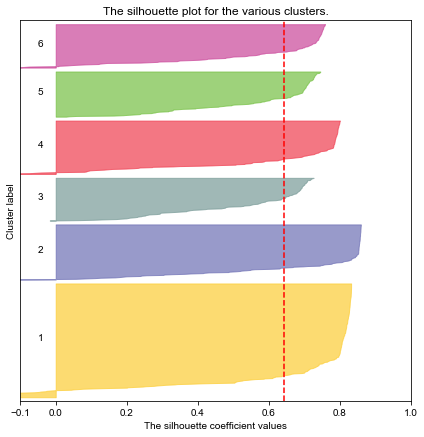

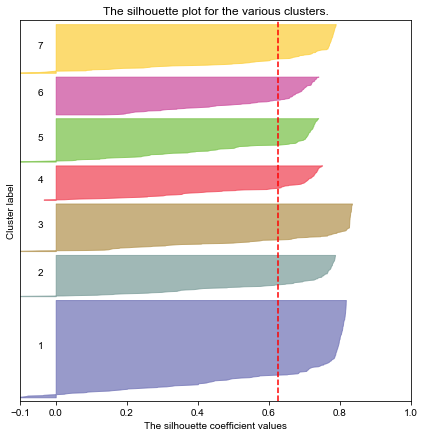

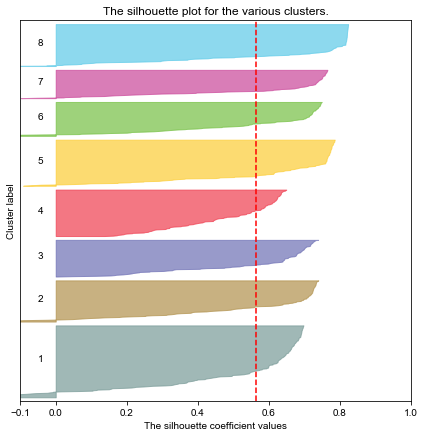

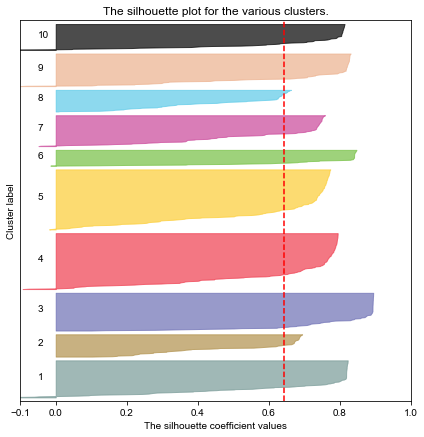

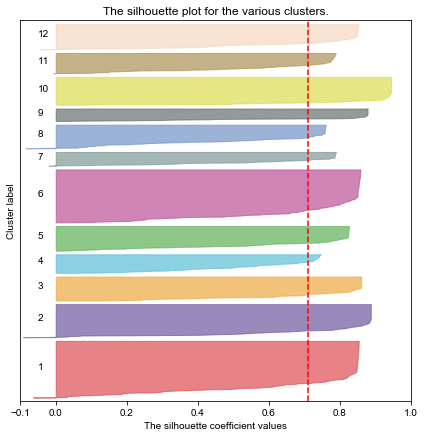

In [56]:
range_n_acores = [6, 7, 8, 10, 12]
rand_n = 1000
perplexity = 100

for acores in range_n_acores:
    filename = 'Mfuzz_cmeans_' + str(acores) + 'acores_' + suffix + '.csv'
    mfuzz_cmeans = pd.DataFrame(pd.read_csv(filename))
    mfuzz_cmeans_val = mfuzz_cmeans.filter(regex=("cluster.*"))
    mfuzz_cmeans['best_cluster'] = mfuzz_cmeans_val.idxmax(axis = 1).str.split('.', expand = True)[1].astype(int)
    mfuzz_cmeans['topval'] = mfuzz_cmeans_val.max(axis = 1)
    mfuzz_cmeans = mfuzz_cmeans.sample(rand_n, axis = 'rows', random_state = 83193)
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(mfuzz_cmeans) + (acores + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    mfuzz_cmeans_dist = mfuzz_cmeans[[col for col in mfuzz_cmeans if col.startswith('cluster.')]]
    mfuzz_cmeans_label = mfuzz_cmeans['best_cluster']

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(mfuzz_cmeans_dist, mfuzz_cmeans_label)
    print("For acores =", acores,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(mfuzz_cmeans_dist, mfuzz_cmeans_label)
    
    colors_dict = {
        5: ['#fccd35', '#6d6fb4', '#789a97', '#ef3d4f', '#75c043'],
        6: ['#fccd35', '#6d6fb4', '#789a97', '#ef3d4f', '#75c043', '#ca4699'],
        7: ['#6d6fb4', '#789a97', '#b1914c', '#ef3d4f', '#75c043', '#ca4699', '#fccd35'],
        8: ['#789a97', '#b1914c', '#6d6fb4', '#ef3d4f', '#fccd35', '#75c043', '#ca4699', '#5dcae8'],
        9: ['#789a97', '#b1914c', '#6d6fb4', '#ef3d4f', '#fccd35', '#75c043', '#ca4699', '#5dcae8', '#ecb18e'],
        10: ['#789a97', '#b1914c', '#6d6fb4', '#ef3d4f', '#fccd35', '#75c043', '#ca4699', '#5dcae8', '#ecb18e', '#000000'],
        12: ['#dd4d54', '#70599f', '#efa941', '#5cbfd8', '#5fb157', '#bb5196', '#7f9996', '#7193c5', '#66706e', '#d9dd50', '#ac9156', '#f6d6be']}
    
    y_lower = 10
    for i in range(1, acores + 1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[mfuzz_cmeans_label == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / acores)
        color = colors_dict[acores][i - 1]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    fig.savefig(Mfuzz_folder_loc + 'Mfuzz_' + str(acores) + 'acores_silhouette_widths.pdf')
    
plt.show()

In [9]:
top_n = 25000
perplexity = 5

multicov_top_n = ImpulseDE2_sorted.head(top_n).loc[:, stages].values

tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
tsne_results = tsne.fit_transform(multicov_top_n)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.001s...
[t-SNE] Computed neighbors for 25000 samples in 24.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sa

<ipython-input-10-1ac9b31e1f86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImpulseDE2_sorted_top_n['tsne-2d-one'] = tsne_results[:,0]
<ipython-input-10-1ac9b31e1f86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ImpulseDE2_sorted_top_n['tsne-2d-two'] = tsne_results[:,1]


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

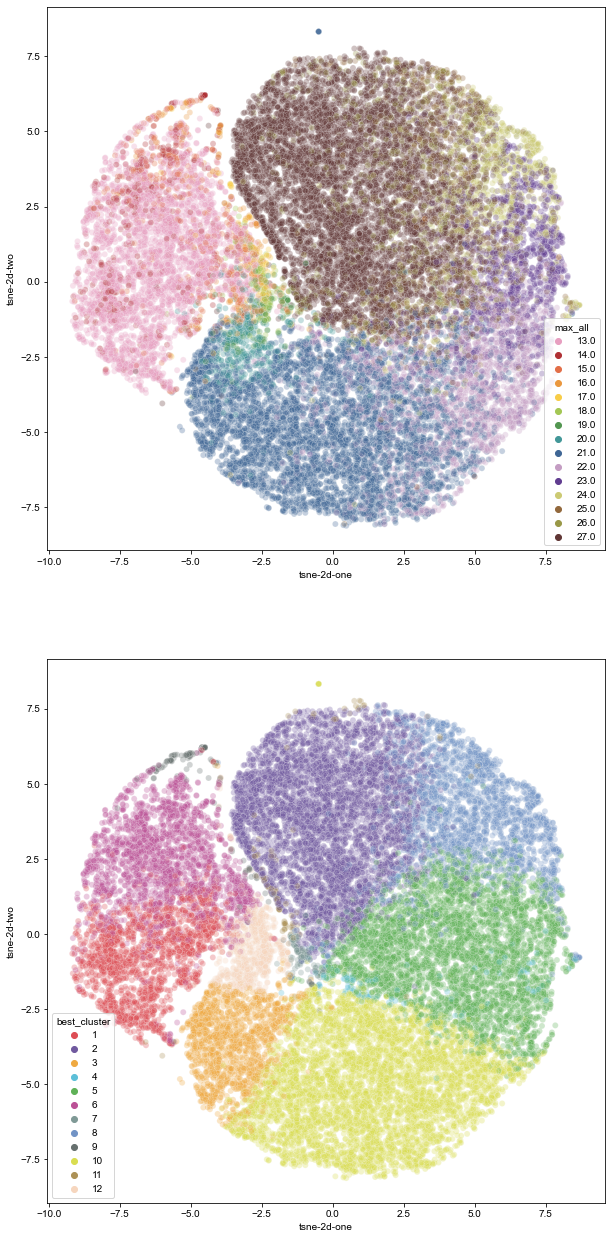

In [10]:
ImpulseDE2_sorted_top_n = ImpulseDE2_sorted.head(top_n)
ImpulseDE2_sorted_top_n['tsne-2d-one'] = tsne_results[:,0]
ImpulseDE2_sorted_top_n['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(10,22))
plt.subplot(2, 1, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="max_all",
    palette=stage_palette,
    data=ImpulseDE2_sorted_top_n,
    alpha=0.3
)
plt.subplot(2, 1, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="best_cluster",
    palette=acore_palette,
    data=ImpulseDE2_sorted_top_n,
    legend = 'full',
    alpha=0.3
)
#plt.savefig(Mfuzz_folder_loc + 'ImpulseDE2_Mfuzz_top' + str(top_n) + '_p' + str(perplexity) + '_c' + str(acores) + '_tsne_multiplot_' + suffix + '.pdf')